In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np

<h2>Settings</h2>

In [2]:
result_dir = ""

compiler_type_vms = ["asmble", "wasmer", "wavm"]

interpreter_type_vms = ["life", "wasmi", "wagon"]

# the list of enabled test names
test_names = ["snappy_compression_5_1000000_1Kb", \
              "snappy_compression_5_10_100Mb", \
              "deflate_compression_5_100000_1Kb", \
              "deflate_compression_5_5_100Mb", \
              "fibonacci_38", \
              "factorization_2147483647", \
              "recursive_hash_10000000_0", \
              "matrix_product_1_10_1000000", \
              "matrix_product_1_500_100", \
              "svd_decomposition_1_10_1000000", \
              "svd_decomposition_1_300_100", \
              "qr_decomposition_1_10_1000000", \
              "qr_decomposition_1_500_100"]

<h2>Import results</h2>

In [3]:
from collections import defaultdict

def read_results(file_name):
    results = defaultdict(list)
    csv_results = pd.read_csv(file_name)
    for test_name, elapsed_time in zip(csv_results["test_name"], csv_results["elapsed_time"]):
        results[test_name].append(elapsed_time)
        
    return results

In [4]:
from os.path import join

vm_results = {}
for compiler_vm in compiler_type_vms:
    vm_results[compiler_vm] = read_results(join(result_dir, compiler_vm + ".csv"))

for interpreter_vm in interpreter_type_vms:
    vm_results[interpreter_vm] = read_results(join(result_dir, interpreter_vm + ".csv"))

<h2>Results preparation</h2>

In [5]:
tests_result = defaultdict(list)
df_results = {}
interpreter_tests_result = {}

for test_name in test_names:
    for vm_name in vm_results:
        tests_result[test_name].append(vm_results[vm_name][test_name])
        
    df_results[test_name] = pd.DataFrame(pd.DataFrame(tests_result[test_name]).T.values, columns=vm_results.keys())

In [6]:
ix3 = pd.MultiIndex.from_arrays([['a', 'a', 'a', 'a', 'b', 'b', 'b', 'b'], ['foo', 'foo', 'bar', 'bar', 'foo', 'foo', 'bar', 'bar']], names=['letter', 'word'])
print(ix3)


MultiIndex(levels=[['a', 'b'], ['bar', 'foo']],
           labels=[[0, 0, 0, 0, 1, 1, 1, 1], [1, 1, 0, 0, 1, 1, 0, 0]],
           names=['letter', 'word'])


In [7]:
df3 = pd.DataFrame({'data1': [3, 2, 4, 3, 2, 4, 3, 2], 'data2': [6, 5, 7, 5, 4, 5, 6, 5]}, index=ix3)
print(df3)

             data1  data2
letter word              
a      foo       3      6
       foo       2      5
       bar       4      7
       bar       3      5
b      foo       2      4
       foo       4      5
       bar       3      6
       bar       2      5


In [8]:
gp3 = df3.groupby(level=('letter', 'word'))
print(gp3)

In [9]:
means = gp3.mean()
print(means)

             data1  data2
letter word              
a      bar     3.5    6.0
       foo     2.5    5.5
b      bar     2.5    5.5
       foo     3.0    4.5


<h2>Result statistics</h2>

In [10]:
for test_name in test_names:
    print("{}\n{}\n".format(test_name, df_results[test_name].describe()))

snappy_compression_5_1000000_1Kb
          asmble     wasmer       wavm         life        wasmi        wagon
count  11.000000  11.000000  11.000000     3.000000     3.000000     3.000000
mean   27.509278  38.289971  13.603409  4489.894337  1982.833807  3561.239060
std     0.139130   0.306925   0.092356     0.698231     1.957743     2.400583
min    27.285796  38.057326  13.558479  4489.130545  1981.034256  3559.698968
25%    27.392895  38.114557  13.566798  4489.591594  1981.791472  3559.856054
50%    27.534367  38.144967  13.572578  4490.052643  1982.548688  3560.013139
75%    27.631515  38.309500  13.583830  4490.276233  1983.733582  3562.009106
max    27.703752  39.042619  13.877442  4490.499823  1984.918476  3564.005073

snappy_compression_5_10_100Mb
          asmble     wasmer       wavm         life        wasmi        wagon
count  11.000000  11.000000  11.000000     3.000000     3.000000     3.000000
mean   20.689402  23.091201   9.644523  2501.841140  1091.431735  1965.293602


<h2>Box plots</h2>

In [200]:
fontsize=15

def adjust_line2D_linewidth(line2d, box_line_width, whisker_line_width, cap_line_width, median_line_width):
    for box in line2d['boxes']:
        box.set(linewidth=box_line_width)
    
    for whisker in line2d['whiskers']:
        whisker.set(linewidth=whisker_line_width)

    for cap in line2d['caps']:
        cap.set(linewidth=cap_line_width)

    for median in line2d['medians']:
        median.set(linewidth=median_line_width)
        
def draw_plotbox(df, column, figsize, test_name, fontsize):
    lines = df.boxplot(figsize=figsize, column=column, return_type='dict', widths=0.5, fontsize=fontsize, showmeans=True)
    adjust_line2D_linewidth(lines, 2, 1, 1, 1)
    plt.title(test_name, fontsize=fontsize)
    plt.ylabel("sec", fontsize=fontsize)
    plt.show()
    
def draw_plot(df, columns, figsize, test_name, fontsize, isLogY=False):
    df[columns].plot(style="o-", figsize=figsize, fontsize=fontsize)
    plt.title(test_name, fontsize=fontsize)
    plt.ylabel("seconds", fontsize=fontsize)
    if isLogY:
        plt.yscale("log")
    plt.grid()
    
def adjust_vm_name(vm_name):
    if vm_name == "life":
        return "   " + vm_name
    if vm_name == "wavm":
        return " " + vm_name
    if len(vm_name) < 6:
        return  vm_name
    
    return vm_name

def draw_plotbar_2(df, figsize, fontsize, title):
    # colors from https://gist.github.com/thriveth/8560036
    ax = df.plot(kind="bar", logy=True, rot=0, fontsize=fontsize+3, figsize=figsize, width=0.5,
                 color=('#377eb8', '#ff7f00', '#4daf4a', '#dede00', '#999999', '#e41a1c'))

    ax.get_legend().remove()
    plt.ylabel("seconds", fontsize=fontsize+5)
    plt.title(title, fontsize=fontsize+10)
    ax.yaxis.grid(True)

    # show column height behind columns
    for p in ax.patches:
        annotate_value = str(np.round(p.get_height(), decimals=2)) if p.get_height() < 1000 else format(np.round(p.get_height()), ".0f")
        ax.annotate(str(annotate_value), (p.get_x()+p.get_width()/2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points', fontsize=15, weight="bold")

    for patch_id in range(6):
        ax.annotate(adjust_vm_name(df.columns[patch_id]), xy=(244 + patch_id * p.get_width()*716, 70), xycoords='figure pixels', fontsize=14)
        patch_id += 1

    for patch_id in range(6):
        ax.annotate(adjust_vm_name(df.columns[patch_id]), xy=(944 + patch_id * p.get_width()*716, 70), xycoords='figure pixels', fontsize=14)
        patch_id += 1


In [201]:
figsize=(25,15)

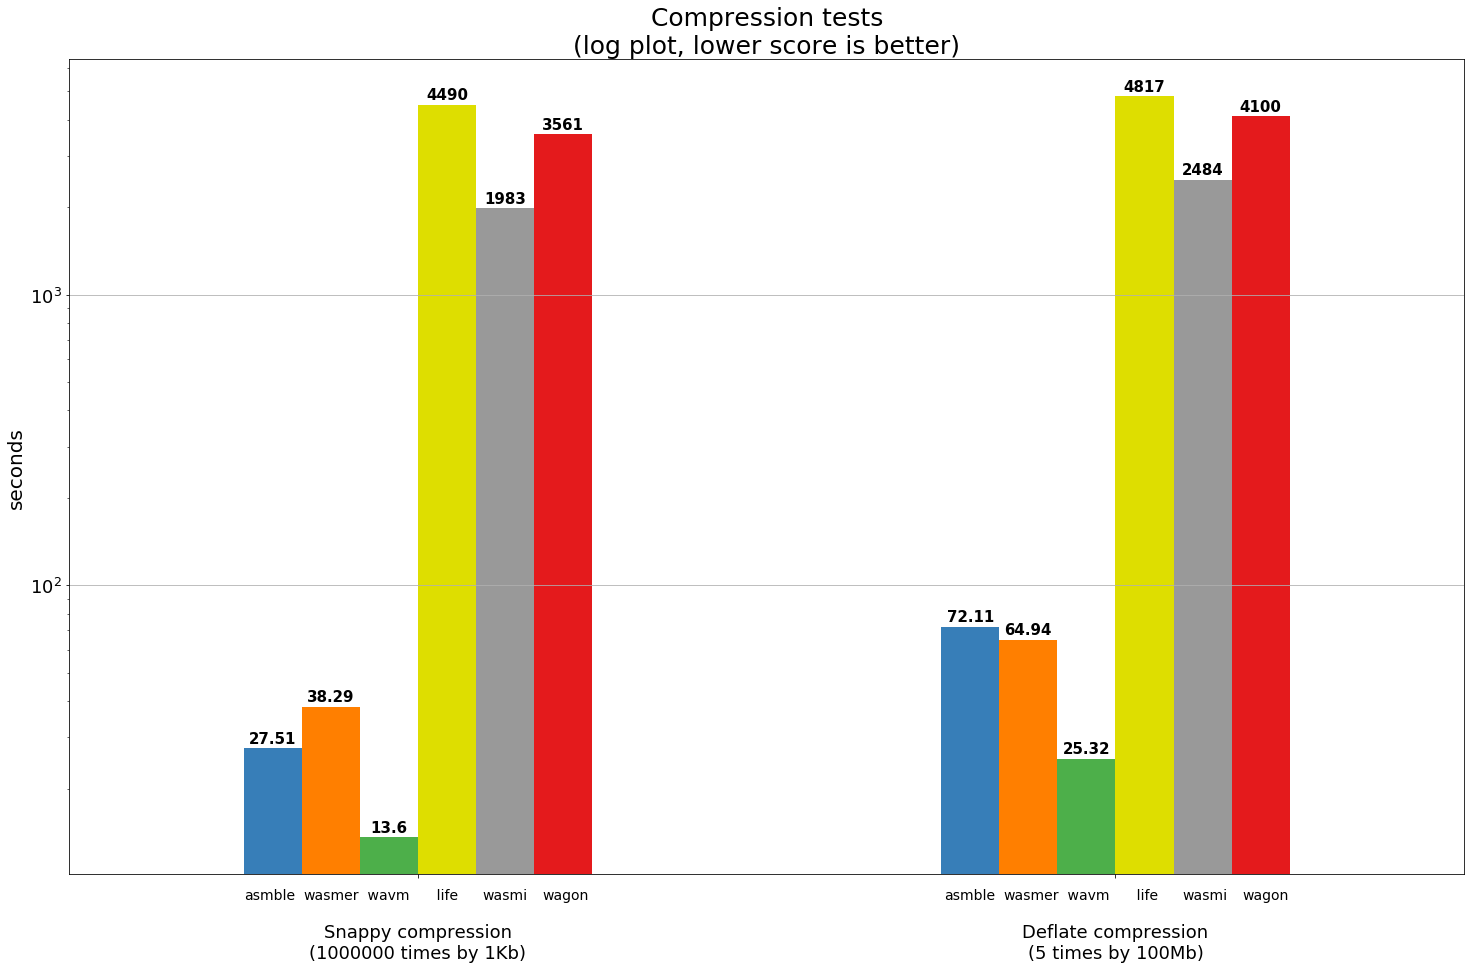

In [202]:
compresssion_tests = pd.DataFrame([df_results["snappy_compression_5_1000000_1Kb"].mean(),
                                   df_results["deflate_compression_5_5_100Mb"].mean()], 
                                  index=["\n\nSnappy compression\n(1000000 times by 1Kb)", 
                                         "\n\nDeflate compression\n(5 times by 100Mb)"])

draw_plotbar_2(compresssion_tests, (25,15), fontsize, "Compression tests\n(log plot, a lower score is better)")


In [197]:
def draw_plotbar_3(df, figsize, fontsize, title):
    ax = df.plot(kind="bar", logy=True, rot=0, fontsize=fontsize+3, figsize=figsize, width=0.8, 
                 color=('#377eb8', '#ff7f00', '#4daf4a', '#dede00', '#999999', '#e41a1c'))

    ax.get_legend().remove()
    plt.ylabel("sec", fontsize=fontsize+5)
    plt.title(title, fontsize=fontsize+10)
    ax.yaxis.grid(True)

    # show column height behind columns
    for p in ax.patches:
        annotate_value = str(np.round(p.get_height(), decimals=2)) if p.get_height() < 500 else format(np.round(p.get_height()), ".0f")
        ax.annotate(str(annotate_value), (p.get_x()+p.get_width()/2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points', fontsize=15, weight="bold")

    for patch_id in range(6):
        ax.annotate(adjust_vm_name(df.columns[patch_id]), xy=(174 + patch_id * p.get_width()*432, 70), xycoords='figure pixels', fontsize=14)
        patch_id += 1

    for patch_id in range(6):
        ax.annotate(adjust_vm_name(df.columns[patch_id]), xy=(599 + patch_id * p.get_width()*432, 70), xycoords='figure pixels', fontsize=14)
        patch_id += 1

    for patch_id in range(6):
        ax.annotate(adjust_vm_name(df.columns[patch_id]), xy=(1019 + patch_id * p.get_width()*432, 70), xycoords='figure pixels', fontsize=14)
        patch_id += 1

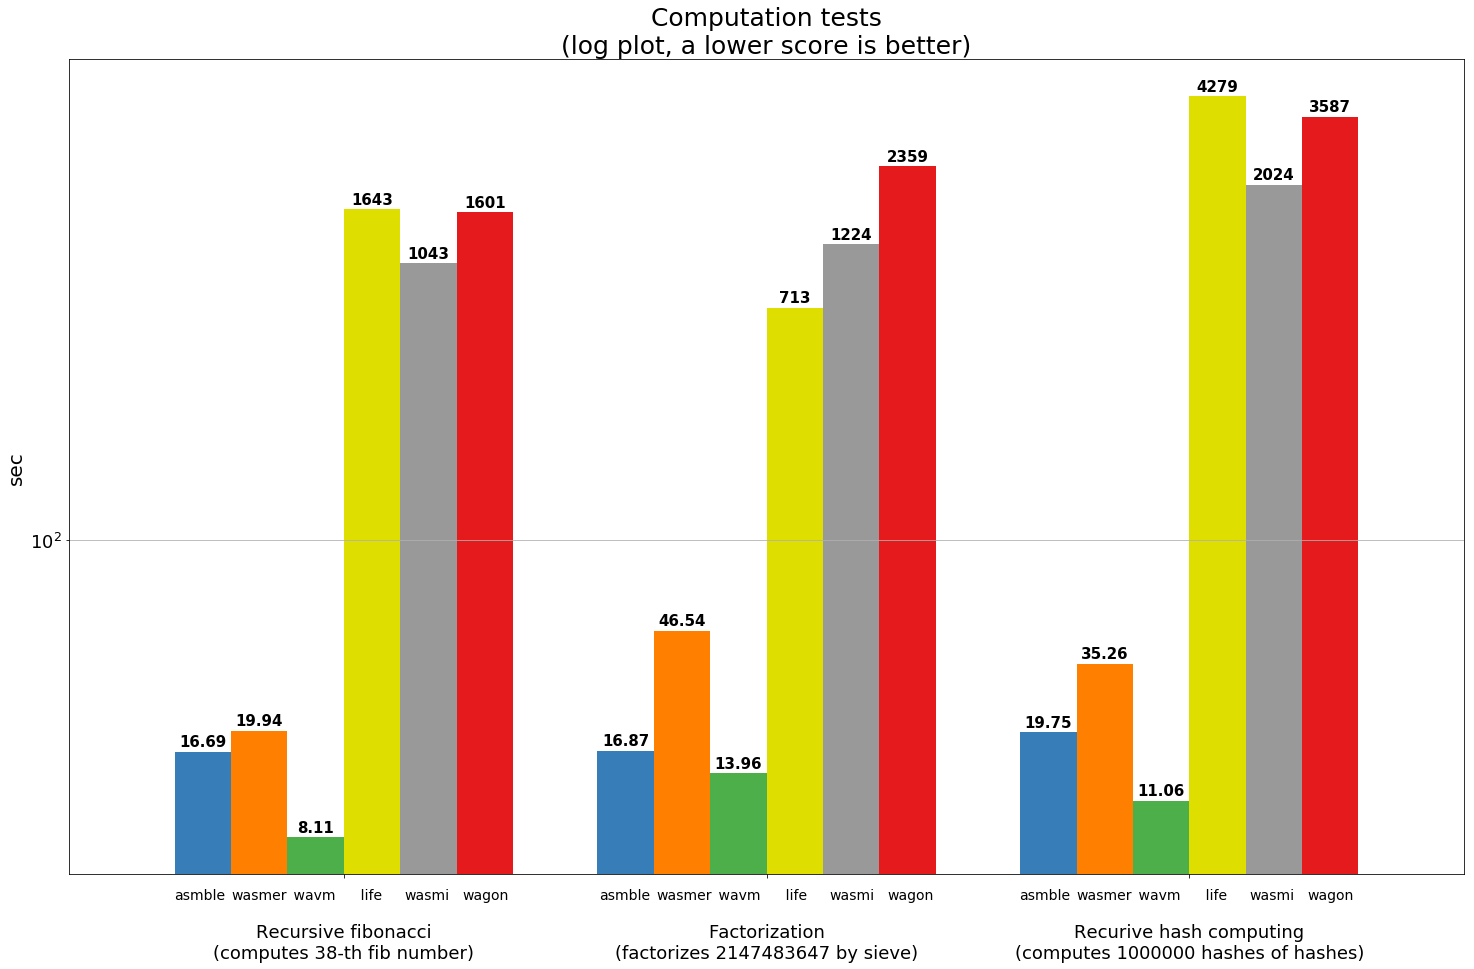

In [203]:
computations_tests = pd.DataFrame([df_results["fibonacci_38"].mean(),
                                   df_results["factorization_2147483647"].mean(), 
                                   df_results["recursive_hash_10000000_0"].mean()],
                                  index=["\n\nRecursive fibonacci\n(computes 38-th fib number)", 
                                         "\n\nFactorization\n(factorizes 2147483647 by sieve)",
                                         "\n\nRecurive hash computing\n(computes 1000000 hashes of hashes)"])

draw_plotbar_3(computations_tests, figsize, fontsize, "Computation tests\n(log plot, a lower score is better)")

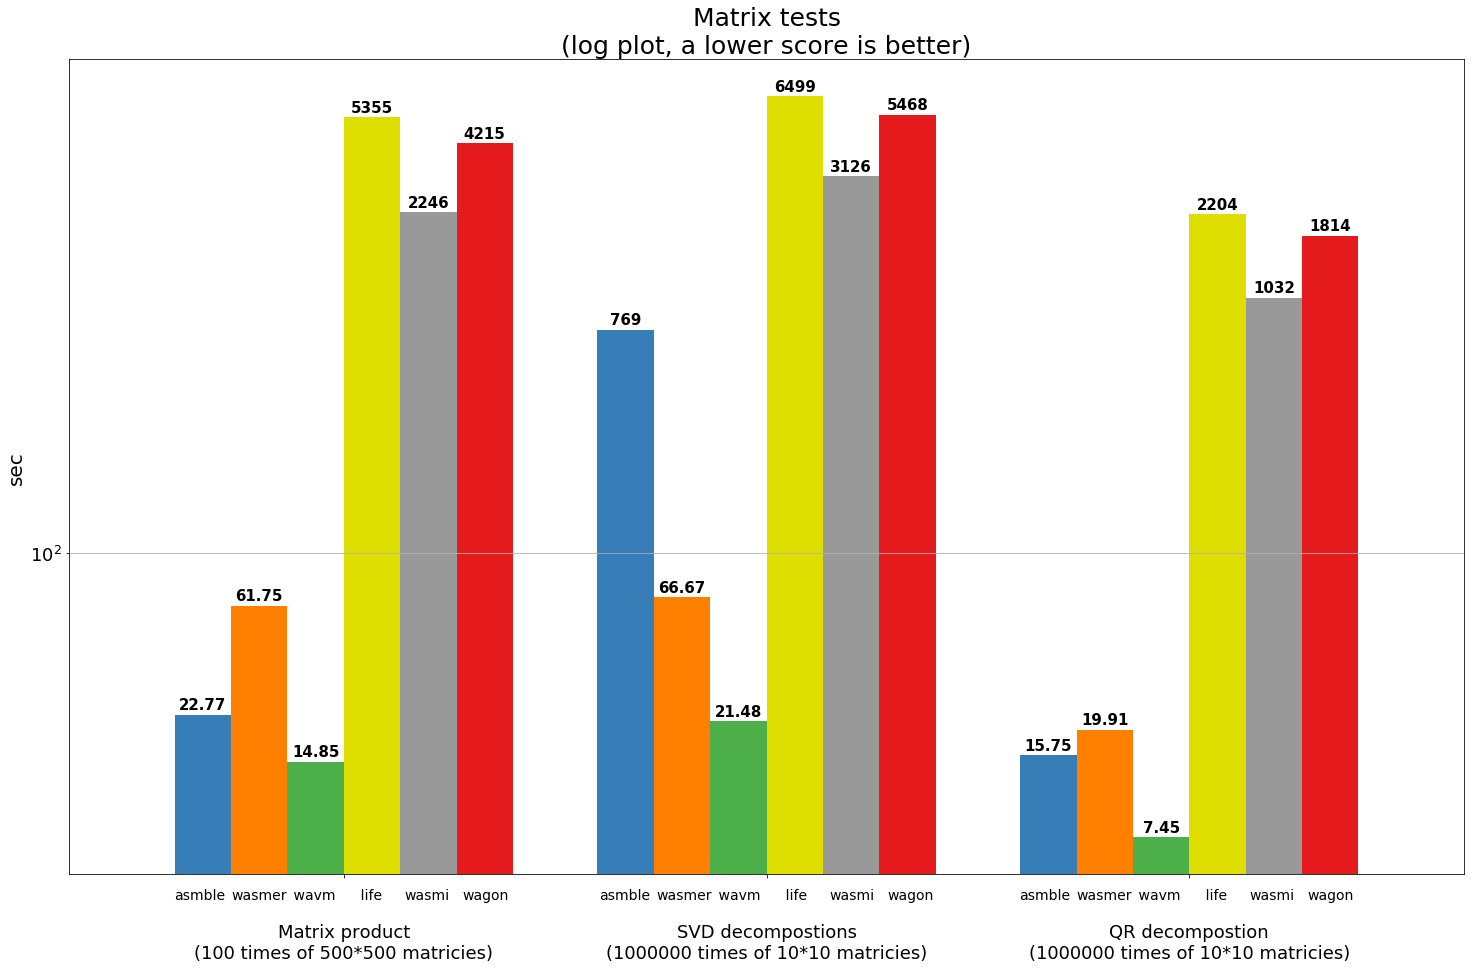

In [204]:
matrix_tests = pd.DataFrame([df_results["matrix_product_1_500_100"].mean(),
                                   df_results["svd_decomposition_1_10_1000000"].mean(), 
                                   df_results["qr_decomposition_1_10_1000000"].mean()],
                                  index=["\n\nMatrix product\n(100 times of 500*500 matricies)", 
                                         "\n\nSVD decompostions\n(1000000 times of 10*10 matricies)",
                                         "\n\nQR decompostion\n(1000000 times of 10*10 matricies)"])

draw_plotbar_3(matrix_tests, figsize, fontsize, "Matrix tests\n(log plot, a lower score is better)")

<h3>snappy_compression_5_1000000_1Kb</h3>

In [ ]:
plot_test_name="snappy_compression_5_1000000_1Kb"
figsize=(20,10)

In [ ]:
compresssion_tests = pd.DataFrame([df_results["snappy_compression_5_1000000_1Kb"].mean(),
                                   df_results["snappy_compression_5_10_100Mb"].mean(),
                                   df_results["deflate_compression_5_100000_1Kb"].mean(),
                                   df_results["deflate_compression_5_5_100Mb"].mean()], 
                                  index=["snappy compression\n(1000000 times by 1Kb)", 
                                         "snappy compression\n(10 times by 100Mb)",
                                         "deflate compression\n(100000 times by 1Kb)",
                                         "deflate compression\n(5 times by 100Mb)"])
compresssion_tests.plot(kind="bar", grid=True, logy=True, rot=0, fontsize=15, figsize=figsize)
#plt.yscale("log")
#plt.grid()
#plt.show()

In [ ]:
import seaborn as sns

plt.yscale("log")
plt.title("snappy_compression_5_1000000_1Kb", fontsize=15)
plt.ylabel("sec", fontsize=15)
means = df_results[plot_test_name].mean()
errors = df_results[plot_test_name].std()

#fig, ax = plt.subplots()
sns.barplot(data=df_results[plot_test_name], ci="sd")
plt.figure(figsize=(12,10))
#plt.grid()
#plt.show()
#means.plot.bar(yerr=errors, ax=ax)

#df_results[plot_test_name].mean().plot(kind="bar", figsize=(12,10), table=True, fontsize=12, style=["o-", "s-"])

In [ ]:

plt.yscale("log")
plt.title("snappy_compression_5_1000000_1Kb", fontsize=15)
plt.ylabel("sec", fontsize=15)
plt.grid()
means = df_results[plot_test_name].mean()
errors = df_results[plot_test_name].std()

df_results[plot_test_name].mean().plot(kind="bar", figsize=(12,10), grid=True, fontsize=12)

In [ ]:
draw_plotbox(df_results[plot_test_name], compiler_type_vms + interpreter_type_vms, figsize, plot_test_name + " (all VMs)", fontsize)

In [ ]:
draw_plot(df_results[plot_test_name], compiler_type_vms + interpreter_type_vms, figsize, plot_test_name + " (all VMs)", fontsize, True)

In [ ]:
draw_plotbox(df_results[plot_test_name], compiler_type_vms, figsize, plot_test_name + " (compiler-type VMs)", fontsize)

In [ ]:
draw_plot(df_results[plot_test_name], compiler_type_vms, figsize, plot_test_name + " (compiler-type VMs)", fontsize)

In [ ]:
draw_plotbox(df_results[plot_test_name], interpreter_type_vms, figsize, plot_test_name + " (interpreter-type VMs)", fontsize)

In [ ]:
draw_plot(df_results[plot_test_name],  interpreter_type_vms, figsize, plot_test_name + " (interpreter-type VMs)", fontsize)

<h3>snappy_compression_5_10_100Mb</h3>

In [ ]:
plot_test_name="snappy_compression_5_10_100Mb"
figsize=(12,10)

In [ ]:
draw_plotbox(df_results[plot_test_name], compiler_type_vms + interpreter_type_vms, figsize, plot_test_name + " (all VMs)", fontsize)

In [ ]:
draw_plot(df_results[plot_test_name], compiler_type_vms + interpreter_type_vms, figsize, plot_test_name + " (all VMs)", fontsize, True)

In [ ]:
draw_plotbox(df_results[plot_test_name], compiler_type_vms, figsize, plot_test_name + " (compiler-type VMs)", fontsize)

In [ ]:
draw_plot(df_results[plot_test_name], compiler_type_vms, figsize, plot_test_name + " (compiler-type VMs)", fontsize)

In [ ]:
draw_plotbox(df_results[plot_test_name], interpreter_type_vms, figsize, plot_test_name + " (interpreter-type VMs)", fontsize)

In [ ]:
draw_plot(df_results[plot_test_name],  interpreter_type_vms, figsize, plot_test_name + " (interpreter-type VMs)", fontsize)

<h3>deflate_compression_5_100000_1Kb</h3>

In [ ]:
plot_test_name="deflate_compression_5_100000_1Kb"
figsize=(12,10)

In [ ]:
draw_plotbox(df_results[plot_test_name], compiler_type_vms + interpreter_type_vms, figsize, plot_test_name + " (all VMs)", fontsize)

In [ ]:
draw_plot(df_results[plot_test_name], compiler_type_vms + interpreter_type_vms, figsize, plot_test_name + " (all VMs)", fontsize, True)

In [ ]:
draw_plotbox(df_results[plot_test_name], compiler_type_vms, figsize, plot_test_name + " (compiler-type VMs)", fontsize)

In [ ]:
draw_plot(df_results[plot_test_name], compiler_type_vms, figsize, plot_test_name + " (compiler-type VMs)", fontsize)

In [ ]:
draw_plotbox(df_results[plot_test_name], interpreter_type_vms, figsize, plot_test_name + " (interpreter-type VMs)", fontsize)

In [ ]:
draw_plot(df_results[plot_test_name],  interpreter_type_vms, figsize, plot_test_name + " (interpreter-type VMs)", fontsize)

<h3>deflate_compression_5_5_100Mb</h3>

In [ ]:
plot_test_name="deflate_compression_5_5_100Mb"
figsize=(12,10)

In [ ]:
draw_plotbox(df_results[plot_test_name], compiler_type_vms + interpreter_type_vms, figsize, plot_test_name + " (all VMs)", fontsize)

In [ ]:
draw_plot(df_results[plot_test_name], compiler_type_vms + interpreter_type_vms, figsize, plot_test_name + " (all VMs)", fontsize, True)

In [ ]:
draw_plotbox(df_results[plot_test_name], compiler_type_vms, figsize, plot_test_name + " (compiler-type VMs)", fontsize)

In [ ]:
draw_plot(df_results[plot_test_name], compiler_type_vms, figsize, plot_test_name + " (compiler-type VMs)", fontsize)

In [ ]:
draw_plotbox(df_results[plot_test_name], interpreter_type_vms, figsize, plot_test_name + " (interpreter-type VMs)", fontsize)

In [ ]:
draw_plot(df_results[plot_test_name],  interpreter_type_vms, figsize, plot_test_name + " (interpreter-type VMs)", fontsize)

<h3>fibonacci_38</h3>

In [ ]:
plot_test_name="fibonacci_38"
figsize=(12,10)

In [ ]:
draw_plotbox(df_results[plot_test_name], compiler_type_vms + interpreter_type_vms, figsize, plot_test_name + " (all VMs)", fontsize)

In [ ]:
draw_plot(df_results[plot_test_name], compiler_type_vms + interpreter_type_vms, figsize, plot_test_name + " (all VMs)", fontsize, True)

In [ ]:
draw_plotbox(df_results[plot_test_name], compiler_type_vms, figsize, plot_test_name + " (compiler-type VMs)", fontsize)

In [ ]:
draw_plot(df_results[plot_test_name], compiler_type_vms, figsize, plot_test_name + " (compiler-type VMs)", fontsize)

In [ ]:
draw_plotbox(df_results[plot_test_name], interpreter_type_vms, figsize, plot_test_name + " (interpreter-type VMs)", fontsize)

In [ ]:
draw_plot(df_results[plot_test_name],  interpreter_type_vms, figsize, plot_test_name + " (interpreter-type VMs)", fontsize)

<h3>factorization_2147483647</h3>

In [ ]:
plot_test_name="factorization_2147483647"
figsize=(12,10)

In [ ]:
draw_plotbox(df_results[plot_test_name], compiler_type_vms + interpreter_type_vms, figsize, plot_test_name + " (all VMs)", fontsize)

In [ ]:
draw_plot(df_results[plot_test_name], compiler_type_vms + interpreter_type_vms, figsize, plot_test_name + " (all VMs)", fontsize, True)

In [ ]:
draw_plotbox(df_results[plot_test_name], compiler_type_vms, figsize, plot_test_name + " (compiler-type VMs)", fontsize)

In [ ]:
draw_plot(df_results[plot_test_name], compiler_type_vms, figsize, plot_test_name + " (compiler-type VMs)", fontsize)

In [ ]:
draw_plotbox(df_results[plot_test_name], interpreter_type_vms, figsize, plot_test_name + " (interpreter-type VMs)", fontsize)

In [ ]:
draw_plot(df_results[plot_test_name],  interpreter_type_vms, figsize, plot_test_name + " (interpreter-type VMs)", fontsize)

<h3>recursive_hash_10000000_0</h3>

In [ ]:
plot_test_name="recursive_hash_10000000_0"
figsize=(12,10)

In [ ]:
draw_plotbox(df_results[plot_test_name], compiler_type_vms + interpreter_type_vms, figsize, plot_test_name + " (all VMs)", fontsize)

In [ ]:
draw_plot(df_results[plot_test_name], compiler_type_vms + interpreter_type_vms, figsize, plot_test_name + " (all VMs)", fontsize, True)

In [ ]:
draw_plotbox(df_results[plot_test_name], compiler_type_vms, figsize, plot_test_name + " (compiler-type VMs)", fontsize)

In [ ]:
draw_plot(df_results[plot_test_name], compiler_type_vms, figsize, plot_test_name + " (compiler-type VMs)", fontsize)

In [ ]:
draw_plotbox(df_results[plot_test_name], interpreter_type_vms, figsize, plot_test_name + " (interpreter-type VMs)", fontsize)

In [ ]:
draw_plot(df_results[plot_test_name],  interpreter_type_vms, figsize, plot_test_name + " (interpreter-type VMs)", fontsize)

<h3>matrix_product_1_10_1000000</h3>

In [ ]:
plot_test_name="matrix_product_1_10_1000000"
figsize=(12,10)

In [ ]:
draw_plotbox(df_results[plot_test_name], compiler_type_vms + interpreter_type_vms, figsize, plot_test_name + " (all VMs)", fontsize)

In [ ]:
draw_plot(df_results[plot_test_name], compiler_type_vms + interpreter_type_vms, figsize, plot_test_name + " (all VMs)", fontsize, True)

In [ ]:
draw_plotbox(df_results[plot_test_name], compiler_type_vms, figsize, plot_test_name + " (compiler-type VMs)", fontsize)

In [ ]:
draw_plot(df_results[plot_test_name], compiler_type_vms, figsize, plot_test_name + " (compiler-type VMs)", fontsize)

In [ ]:
draw_plotbox(df_results[plot_test_name], interpreter_type_vms, figsize, plot_test_name + " (interpreter-type VMs)", fontsize)

In [ ]:
draw_plot(df_results[plot_test_name],  interpreter_type_vms, figsize, plot_test_name + " (interpreter-type VMs)", fontsize)

<h3>matrix_product_1_500_100</h3>

In [ ]:
plot_test_name="matrix_product_1_500_100"
figsize=(12,10)

In [ ]:
draw_plotbox(df_results[plot_test_name], compiler_type_vms + interpreter_type_vms, figsize, plot_test_name + " (all VMs)", fontsize)

In [ ]:
draw_plot(df_results[plot_test_name], compiler_type_vms + interpreter_type_vms, figsize, plot_test_name + " (all VMs)", fontsize, True)

In [ ]:
draw_plotbox(df_results[plot_test_name], compiler_type_vms, figsize, plot_test_name + " (compiler-type VMs)", fontsize)

In [ ]:
draw_plot(df_results[plot_test_name], compiler_type_vms, figsize, plot_test_name + " (compiler-type VMs)", fontsize)

In [ ]:
draw_plotbox(df_results[plot_test_name], interpreter_type_vms, figsize, plot_test_name + " (interpreter-type VMs)", fontsize)

In [ ]:
draw_plot(df_results[plot_test_name],  interpreter_type_vms, figsize, plot_test_name + " (interpreter-type VMs)", fontsize)

<h3>svd_decomposition_1_10_1000000</h3>

In [ ]:
plot_test_name="svd_decomposition_1_10_1000000"
figsize=(12,10)

In [ ]:
draw_plotbox(df_results[plot_test_name], compiler_type_vms + interpreter_type_vms, figsize, plot_test_name + " (all VMs)", fontsize)

In [ ]:
draw_plot(df_results[plot_test_name], compiler_type_vms + interpreter_type_vms, figsize, plot_test_name + " (all VMs)", fontsize, True)

In [ ]:
draw_plotbox(df_results[plot_test_name], compiler_type_vms, figsize, plot_test_name + " (compiler-type VMs)", fontsize)

In [ ]:
draw_plot(df_results[plot_test_name], compiler_type_vms, figsize, plot_test_name + " (compiler-type VMs)", fontsize)

In [ ]:
draw_plotbox(df_results[plot_test_name], interpreter_type_vms, figsize, plot_test_name + " (interpreter-type VMs)", fontsize)

In [ ]:
draw_plot(df_results[plot_test_name],  interpreter_type_vms, figsize, plot_test_name + " (interpreter-type VMs)", fontsize)

<h3>svd_decomposition_1_300_100</h3>

In [ ]:
plot_test_name="svd_decomposition_1_300_100"
figsize=(12,10)

In [ ]:
draw_plotbox(df_results[plot_test_name], compiler_type_vms + interpreter_type_vms, figsize, plot_test_name + " (all VMs)", fontsize)

In [ ]:
draw_plot(df_results[plot_test_name], compiler_type_vms + interpreter_type_vms, figsize, plot_test_name + " (all VMs)", fontsize, True)

In [ ]:
draw_plotbox(df_results[plot_test_name], compiler_type_vms, figsize, plot_test_name + " (compiler-type VMs)", fontsize)

In [ ]:
draw_plot(df_results[plot_test_name], compiler_type_vms, figsize, plot_test_name + " (compiler-type VMs)", fontsize)

In [ ]:
draw_plotbox(df_results[plot_test_name], interpreter_type_vms, figsize, plot_test_name + " (interpreter-type VMs)", fontsize)

In [ ]:
draw_plot(df_results[plot_test_name],  interpreter_type_vms, figsize, plot_test_name + " (interpreter-type VMs)", fontsize)

<h3>qr_decomposition_1_10_1000000</h3>

In [ ]:
plot_test_name="qr_decomposition_1_10_1000000"
figsize=(12,10)

In [ ]:
draw_plotbox(df_results[plot_test_name], compiler_type_vms + interpreter_type_vms, figsize, plot_test_name + " (all VMs)", fontsize)

In [ ]:
draw_plot(df_results[plot_test_name], compiler_type_vms + interpreter_type_vms, figsize, plot_test_name + " (all VMs)", fontsize, True)

In [ ]:
draw_plotbox(df_results[plot_test_name], compiler_type_vms, figsize, plot_test_name + " (compiler-type VMs)", fontsize)

In [ ]:
draw_plot(df_results[plot_test_name], compiler_type_vms, figsize, plot_test_name + " (compiler-type VMs)", fontsize)

In [ ]:
draw_plotbox(df_results[plot_test_name], interpreter_type_vms, figsize, plot_test_name + " (interpreter-type VMs)", fontsize)

In [ ]:
draw_plot(df_results[plot_test_name],  interpreter_type_vms, figsize, plot_test_name + " (interpreter-type VMs)", fontsize)

<h3>qr_decomposition_1_500_100</h3>

In [ ]:
plot_test_name="qr_decomposition_1_500_100"
figsize=(12,10)

In [ ]:
draw_plotbox(df_results[plot_test_name], compiler_type_vms + interpreter_type_vms, figsize, plot_test_name + " (all VMs)", fontsize)

In [ ]:
draw_plot(df_results[plot_test_name], compiler_type_vms + interpreter_type_vms, figsize, plot_test_name + " (all VMs)", fontsize, True)

In [ ]:
draw_plotbox(df_results[plot_test_name], compiler_type_vms, figsize, plot_test_name + " (compiler-type VMs)", fontsize)

In [ ]:
draw_plot(df_results[plot_test_name], compiler_type_vms, figsize, plot_test_name + " (compiler-type VMs)", fontsize)

In [ ]:
draw_plotbox(df_results[plot_test_name], interpreter_type_vms, figsize, plot_test_name + " (interpreter-type VMs)", fontsize)

In [ ]:
draw_plot(df_results[plot_test_name],  interpreter_type_vms, figsize, plot_test_name + " (interpreter-type VMs)", fontsize)